# SM2 — Split Weeks (Atrea vs ThermoPro) — August 2025 — Public Dataset

**Purpose:** Provide simple weekly plots for August 2025, split by source, so it’s easy to compare summer behavior across systems.

### What this notebook shows
- **Atrea (penultimate week of August 2025):** Hourly temperature traces for section‑level signals. Look for daily cycles, peak days, and differences between keys (e.g., `temp_indoor`, `temp_fresh`, `temp_intake`, `temp_ambient` if included).
- **ThermoPro (last week of August 2025):** Hourly indoor corridor temperatures by location (e.g., `5NP‑S*`). Look for how corridors heat up during the day and which sections tend to run hotter.

> Time handling: dataset timestamps are **UTC**; weekly windows are defined in UTC (end exclusive). Visual reading is in the local daily rhythm.


In [1]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Google Drive IDs
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz (fallback)
USE_PARQUET = True

parquet_path = Path("sm2_public_dataset.parquet")
csvgz_path   = Path("sm2_public_dataset.csv.gz")

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])  # noqa
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print("Stahuji Parquet…")
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print("Stahuji CSV.GZ…")
        gdown_download(CSVGZ_ID, csvgz_path)


Stahuji Parquet…


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 38.2MB/s]


In [3]:
# Load dataset
if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression="gzip")
else:
    raise FileNotFoundError("Dataset nebyl stažen – zkontrolujte připojení a ID souboru.")

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
print("Rozsah času:", df['time'].min(), "→", df['time'].max())
print("Zdroje:", sorted(df['source'].unique()))
print("Metriky:", sorted(df['data_key'].unique()))


Rozsah času: 2023-11-30 13:00:00+00:00 → 2025-09-02 16:34:00+00:00
Zdroje: ['Atrea', 'ThermoPro']
Metriky: ['humidity_indoor', 'temp_ambient', 'temp_fresh', 'temp_indoor', 'temp_intake', 'temp_waste']


In [4]:
# Define weeks (UTC, end exclusive)
ATREA_START = pd.Timestamp('2025-08-18 00:00:00', tz='UTC')
ATREA_END   = pd.Timestamp('2025-08-25 00:00:00', tz='UTC')
THERMO_START = pd.Timestamp('2025-08-25 00:00:00', tz='UTC')
THERMO_END   = pd.Timestamp('2025-09-01 00:00:00', tz='UTC')

atrea_week = df[(df['source'] == 'Atrea') & (df['time'] >= ATREA_START) & (df['time'] < ATREA_END)].copy()
thermo_week = df[(df['source'] == 'ThermoPro') & (df['time'] >= THERMO_START) & (df['time'] < THERMO_END)].copy()

print(f"Atrea – řádků: {len(atrea_week):,}  | interval: {ATREA_START} → {ATREA_END} (UTC)")
print(f"ThermoPro – řádků: {len(thermo_week):,} | interval: {THERMO_START} → {THERMO_END} (UTC)")


Atrea – řádků: 4,181  | interval: 2025-08-18 00:00:00+00:00 → 2025-08-25 00:00:00+00:00 (UTC)
ThermoPro – řádků: 4,780 | interval: 2025-08-25 00:00:00+00:00 → 2025-09-01 00:00:00+00:00 (UTC)


In [5]:
def unit_for_key(key: str) -> str:
    if isinstance(key, str) and key.startswith('temp_'):
        return 'Teplota (°C)'
    if isinstance(key, str) and key.startswith('humidity_'):
        return 'Vlhkost (%)'
    return 'Hodnota'

os.makedirs('plots', exist_ok=True)
os.makedirs('plots/Atrea', exist_ok=True)
os.makedirs('plots/ThermoPro', exist_ok=True)

def plot_group(subset: pd.DataFrame, src_label: str, title_suffix: str, fname_suffix: str):
    if subset.empty:
        print(f"⚠️ {src_label}: žádná data v období – přeskočeno.")
        return
    for key, g in subset.groupby('data_key'):
        piv = (g.groupby(['time','location'])['data_value']
                 .mean()
                 .unstack('location')
                 .sort_index())
        if piv is None or piv.empty:
            print(f"(přeskočeno) {src_label} / {key}: žádná data po pivotu")
            continue
        fig = plt.figure()
        ax = plt.gca()
        piv.plot(ax=ax, legend=True)
        ax.set_title(f"{src_label} – {key} – {title_suffix}")
        ax.set_xlabel("Čas (UTC)")
        ax.set_ylabel(unit_for_key(key))
        ax.grid(True, which='both', axis='both', alpha=0.3)
        plt.tight_layout()
        safe_key = str(key).replace('/', '-')
        outdir = f"plots/{src_label}"
        fname = f"{outdir}/{src_label}_{safe_key}_{fname_suffix}.png"
        plt.savefig(fname, dpi=150)
        plt.show()
    print(f"✅ {src_label}: hotovo. Grafy jsou v plots/{src_label}/")


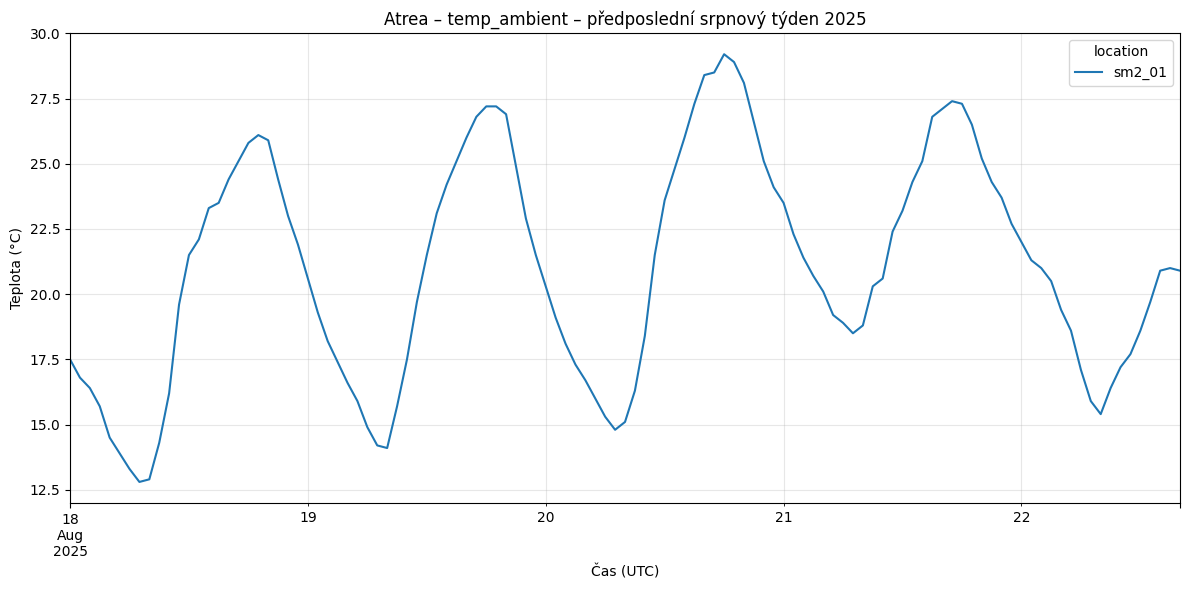

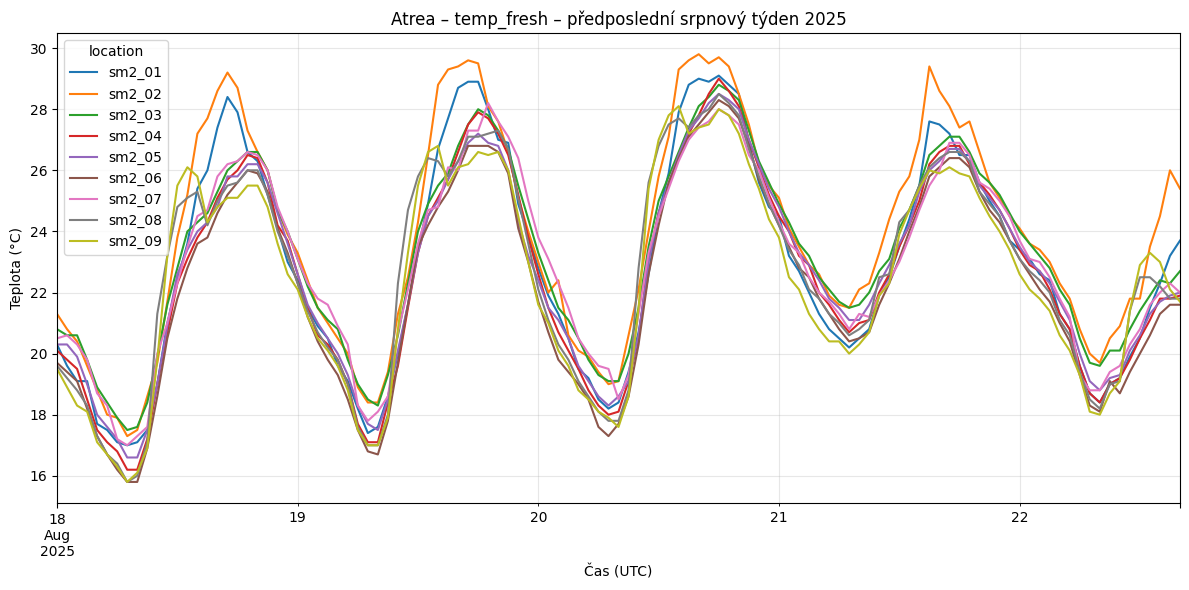

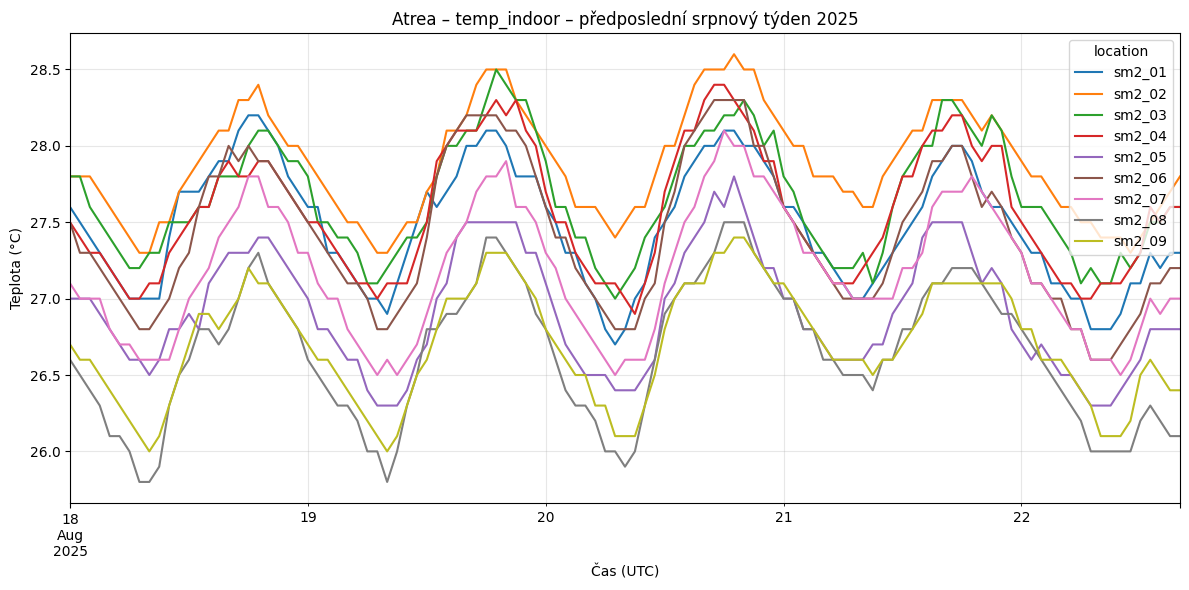

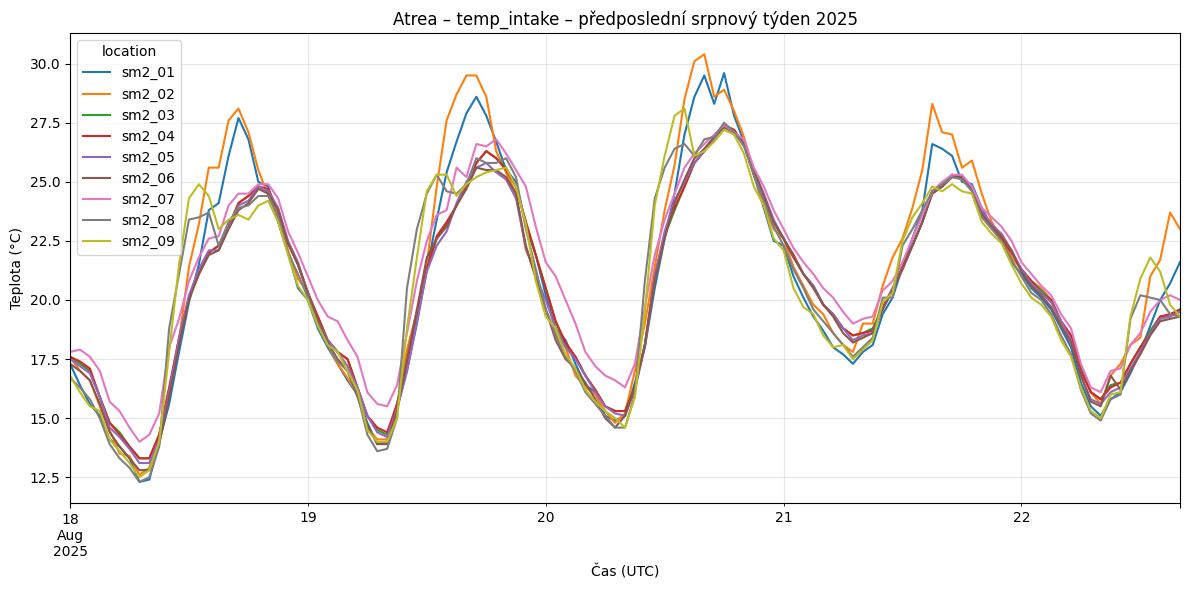

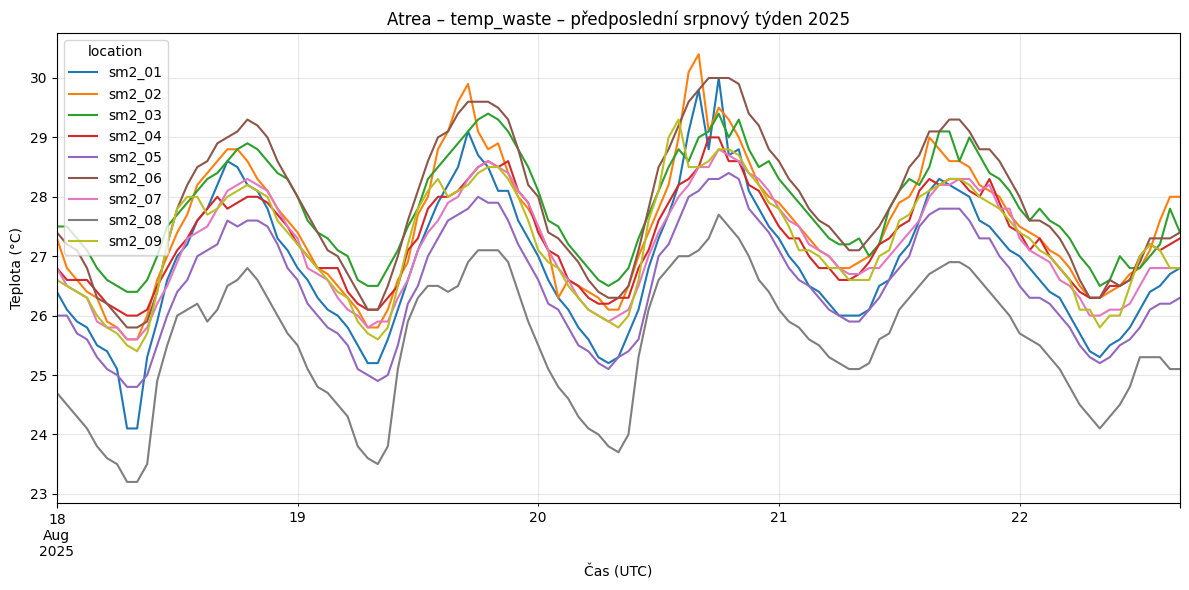

✅ Atrea: hotovo. Grafy jsou v plots/Atrea/


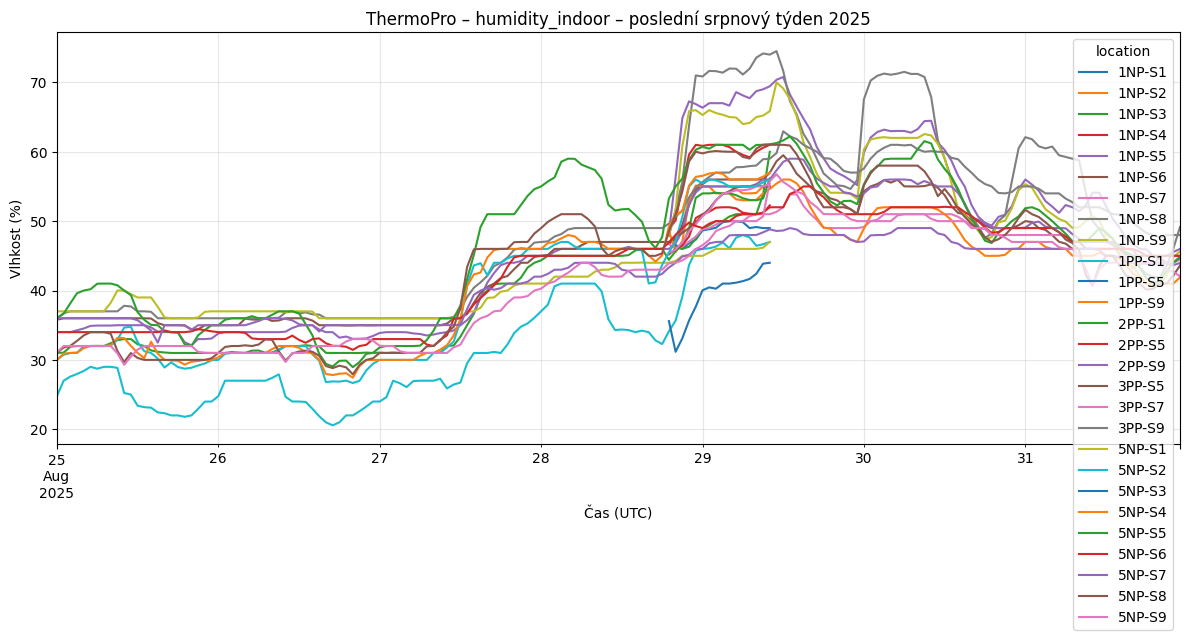

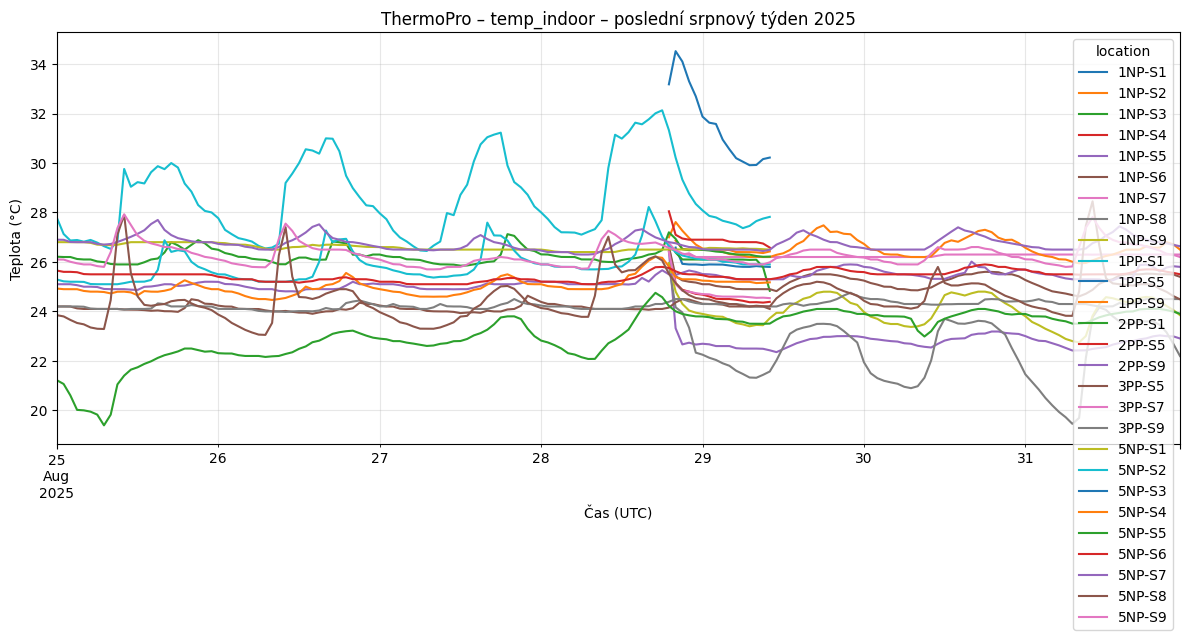

✅ ThermoPro: hotovo. Grafy jsou v plots/ThermoPro/


In [6]:
# Plotting
plot_group(atrea_week, 'Atrea', 'předposlední srpnový týden 2025', '2025-08-18_2025-08-24')
plot_group(thermo_week, 'ThermoPro', 'poslední srpnový týden 2025', '2025-08-25_2025-08-31')
